In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device="cuda")
queries = [
    "Artiklen undersøger kunstig intelligens og machine learning.",
    "Teksten handler om AI-politik, regulering og etik.",
    "Dette dokument beskriver AI-teknologi, GPT og automatisering.",
    "Artiklen diskuterer brugen af robotter og generativ AI."
]

keywords_query = ["AI", "kunstig intelligens", "maskinlæring", "dyb læring", "neural netværk", "automatisering",
                  "robotik", "dataanalyse", "algoritme", "intelligente systemer", "GPT", "OPENAI", "LLM", "chatbot",
                    "sprogmodel", "generativ AI", "AI-assistent", "AI-drevet", "computer vision", "naturlig sprogbehandling",
                    "AI-platform", "AI-teknologi", "AI-forskning", "AI-innovation", "AI-applikationer", "AI-løsninger",
                    "AI-udvikling", "AI-sikkerhed", "AI-etik", "AI-regulering", "AI-politik", "AI-strategi", "AI-investering",
                    "AI-startup", "AI-industrien", "AI-marked", "AI-trends", "AI-fremtid", "robotter", "automatiserede systemer",
                    "intelligente maskiner", "AI-integration", "AI-implementering", "AI-optimering", "AI-overvågning",]

E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import re

emb = np.load("results/01_embeddings.npy")
df = pd.read_csv("results/00_raw_data.csv")
ai_vec = model.encode(queries, normalize_embeddings=True)
query_vec = np.mean(ai_vec, axis=0)

true_score =  util.cos_sim(emb, ai_vec)
ai_final_score = true_score.mean(dim=1)
# 1) 先把 keywords 分成 “短词” 和 “长词”
short_keywords = [kw for kw in keywords_query
                  if len(kw) <= 3 and " " not in kw]
long_keywords = [kw for kw in keywords_query
                 if kw not in short_keywords]

short_patterns = {
    kw: re.compile(r"\b" + re.escape(kw.lower()) + r"\b", flags=re.IGNORECASE)
    for kw in short_keywords
}

keyword_scores = []

for index, row in df.iterrows():
    text = row['plain_text']
    text_lower = text.lower()

    score = 0

    # 长关键词：子串匹配即可
    score += sum(
        1 for kw in long_keywords
        if kw.lower() in text_lower
    )

    score += sum(
        1 for kw, pattern in short_patterns.items()
        if pattern.search(text_lower)
    )

    keyword_scores.append(score)

keyword_scores = np.array(keyword_scores)
# assign to column
df['keyword_score'] = keyword_scores


df["ai_score"] = ai_final_score

df["is_ai"] = df["ai_score"] > 0
# and keyword score > 0
df["is_ai"] = df["is_ai"] & (df["keyword_score"] > 0)

df.to_csv("results/02_ai_scores_v2.csv", index=False)

print("AI-related articles:", df["is_ai"].sum())



AI-related articles: 7146


In [3]:
# ai score vs keyword score correlation
correlation = np.corrcoef(df["ai_score"], df["keyword_score"])[0, 1]
print("Correlation between AI score and Keyword score:", correlation)



Correlation between AI score and Keyword score: 0.08040084813381242


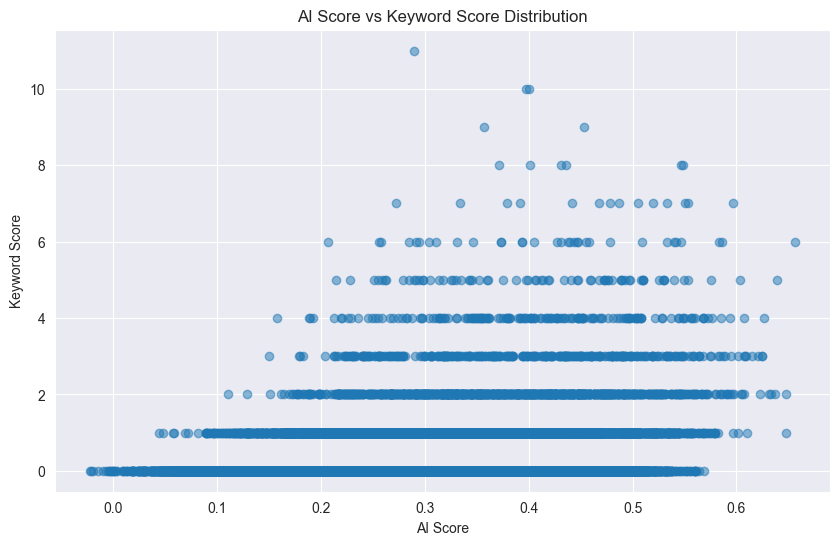

In [4]:
# plot ai score vs keyword score distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df["ai_score"], df["keyword_score"], alpha=0.5)
plt.title("AI Score vs Keyword Score Distribution")
plt.xlabel("AI Score")
plt.ylabel("Keyword Score")
plt.savefig("figures/ai_score_vs_keyword_score.png")
plt.show()

In [5]:
import pandas as pd
import numpy as np
import ollama

# 从最高 ai_score 的前 500 条里随机 100 条
sample_ai = (
    df.sort_values(by="ai_score", ascending=False)
      .iloc[:500]
      .sample(n=100, random_state=42)
      .copy()
)
sample_ai["score_source"] = "ai_score"        # 标记来源
sample_ai["score_bucket"] = "top500"          # 想分桶就简单写个 tag



# 合并
sample_df = sample_ai

print(f"Total samples for Ollama: {len(sample_df)}")  # 应该是 200
sample_df.to_csv("results/03_ai_sample_for_ollama_top500.csv", index=False)
print("Saved sample to results/03_ai_sample_for_ollama_top500.csv")



Total samples for Ollama: 100
Saved sample to results/03_ai_sample_for_ollama_top500.csv


In [6]:
df[df.keyword_score>0].shape

(7146, 11)

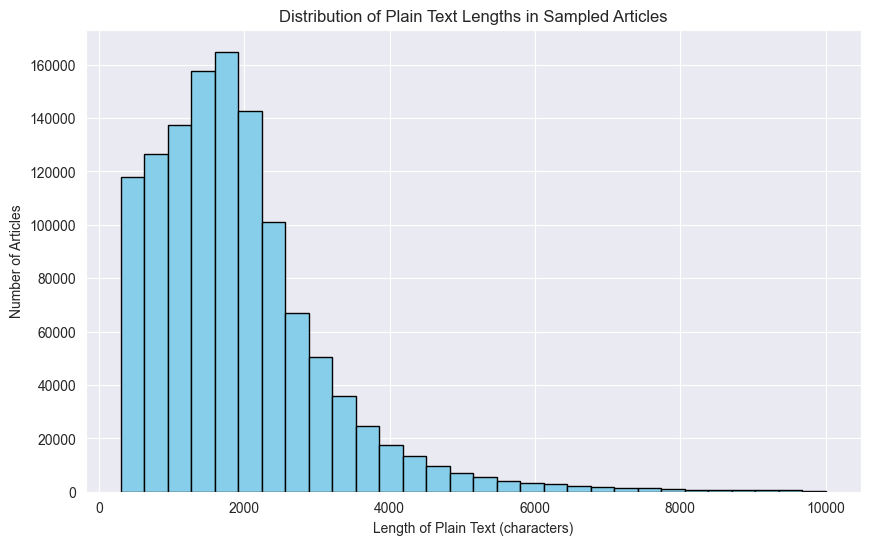

In [7]:
# length of plain_text distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df["plain_text"].dropna().apply(len), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Plain Text Lengths in Sampled Articles")
plt.xlabel("Length of Plain Text (characters)")
plt.ylabel("Number of Articles")
plt.show()

In [7]:
import numpy as np

# 1. 先生成两个方法自己的二值预测（阈值先用 > 0，之后你可以调）
results_df["pred_ai_score"] = results_df["ai_score"].fillna(0) > 0

# 2. 按来源分别创建 mask
mask_ai = results_df["score_source"] == "ai_score"

# 3. 对于 ai_score 抽出来的那 100 条，用 pred_ai_score 和 Ollama 比
acc_ai = (results_df.loc[mask_ai, "pred_ai_score"] ==
          results_df.loc[mask_ai, "is_ai_ollama"]).mean()


print(f"Accuracy for top500-high ai_score (threshold > 0): {acc_ai * 100:.2f}%")



Accuracy for top500-high ai_score (threshold > 0): 55.00%


In [9]:
results = []

def check_ai_via_ollama(text: str) -> bool:
    prompt = (
        "You are a strict AI detector.\n"
        "Question: Is the following article mainly about artificial intelligence (AI), "
        "machine learning, GPT, or automation?\n"
        "Answer strictly with only one word: 'ja' for yes and 'nej' for no.\n\n"
        f"Article:\n{text}\n\n"
        "Answer:"
    )

    response = ollama.chat(

        model="gemma3:latest",
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    content = response["message"]["content"].strip().lower()
    if content.startswith("ja"):
        return True
    if content.startswith("nej"):
        return False
    # 不听话就当不是AI
    return False


# use tqdm for progress bar
from tqdm import tqdm

for index, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    text = (row["plain_text"] or "")[:2000]

    is_ai = check_ai_via_ollama(text)

    results.append({
        "orig_index": row.name,                  # 原始df的index
        "ai_score": row["ai_score"],
        "keyword_score": row["keyword_score"],
        "is_ai_ollama": is_ai,
        "total_length": len(text),
        "score_source": row["score_source"],
        "score_bucket": row["score_bucket"],
  # 属于哪个百分位区间
    })

results_df = pd.DataFrame(results)


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


In [8]:
results_df

,orig_index,ai_score,keyword_score,is_ai_ollama,total_length,score_source,score_bucket,pred_ai_score
0,327473,0.523851,1,True,2000,ai_score,top500,True
1,1080840,0.567622,4,True,1210,ai_score,top500,True
2,267304,0.522955,0,False,2000,ai_score,top500,True
3,1024341,0.547176,0,False,653,ai_score,top500,True
4,945967,0.558508,4,True,2000,ai_score,top500,True
...,...,...,...,...,...,...,...,...
95,862836,0.525352,0,False,447,ai_score,top500,True
96,28344,0.563229,1,True,2000,ai_score,top500,True
97,886600,0.567236,2,True,2000,ai_score,top500,True
98,1080407,0.518611,3,True,371,ai_score,top500,True


In [10]:
# find those ai ollama true in original df
ai_indices = results_df[results_df["is_ai_ollama"] == True]["orig_index"].unique()
# output that plain text to ternimal
for idx in ai_indices:

    print(sample_df.loc[idx, "plain_text"])
    print("-" * 80)


Efter 14 år som del af Universal Robots har medstifter og robotudvikler Esben Østergaard haft sin sidste dag i Odenses mest succesfulde robotvirksomhed Universal Robots, der om nogen er blevet billedet på den robot-klynge, som er skabt i Odense.  Han sørgede for at annoncere det allerede fredag, så ingen var i tvivl om, hvorvidt der var tale om en aprilsnar, men den er god nok. Stifteren af Odenses mest succesfulde robotvirksomhed - milliardforretningen Universal Robots (UR) - har haft sin sidste dag hos robotproducenten i Odense efter 14 år. Esben Østergaard meddelte fredag aften i en video på onlinemediet Linkedin, at han har trukket stikket og sluppet grebet i den virksomhed, han var med til at udvikle og stifte (i 2005, red.) som del af en trio på SDU. - I dag var en meget speciel dag for mig. Det var mit sidste dag i det firma, jeg selv var med til at stifte for 14 år siden, siger Esben Østergaard i videoen. Til Fyens Stiftstidende uddyber han: - UR kan stadig bruge mig som konsul

In [11]:
import numpy as np

def auto_thresholds_from_scores(scores, n=7, trim_ends=True):

    scores = np.asarray(scores)
    scores = scores[~np.isnan(scores)]

    if scores.size == 0:
        return []

    if trim_ends:
        # 例如 n=7 → 取 10%, 20%, ..., 80%, 90%
        qs = np.linspace(0.1, 0.9, n)
    else:
        qs = np.linspace(0.0, 1.0, n+2)[1:-1]  # 去掉 0 和 1

    thr = np.quantile(scores, qs)
    thr = np.unique(thr)  # 去重一下
    return thr


In [12]:
# -*- coding: utf-8 -*-
"""
Full evaluation script:
- Sample data in several different ways
- Call Ollama to label whether each article is AI-related
- Compare ai_score vs ai_score_simple
- Collect all metrics into a single report table (DataFrame + CSV)
"""

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import ollama
from tqdm import tqdm

# ------------------------------------------------------------
# 0. CONFIG
# ------------------------------------------------------------

MODEL_NAME = "gemma3:latest"    # Ollama model name
MAX_TEXT_LEN = 2000             # 每篇文章截断长度（字符数）
GLOBAL_RANDOM_N = 300           # 全局随机抽样数量
TOP_K = 500                     # topK 高分池
TOP_SAMPLE_N = 100              # 从 topK 中随机抽多少
STRAT_N_BINS = 5                # 分位桶数（0-20,20-40,...）
STRAT_N_PER_BIN = 60            # 每个分位桶抽多少
DISAGREE_N_PER_ZONE = 80        # 每种“分歧类型”抽多少
DISAGREE_HIGH_T = 0.08          # “高分”阈值（ai 高 / simple 高）
DISAGREE_LOW_T = 0.0            # “低分”阈值（ai 低 / simple 低）
THRESHOLDS = auto_thresholds_from_scores(df['ai_score'], n=5, trim_ends=True) # 用来扫不同阈值的列表

# ------------------------------------------------------------
# 1. 报表收集器：所有指标都往这里塞
# ------------------------------------------------------------

report_rows = []

def add_row(subset, method, bucket, metric, value, n_samples):
    """
    subset: 哪类样本（global_random / top500_high / stratified_quintile / disagree 等）
    method: 哪个打分方法（ai_score / ai_score_simple）
    bucket: 子分组，比如 'all' 或 '0-20%' / '80-100%' / 'ai_high_simple_low'
    metric: 指标名称，比如 'auc', 'accuracy_thr>0.05'
    value: 指标值（float）
    n_samples: 该组样本数
    """
    report_rows.append({
        "subset": subset,
        "method": method,
        "bucket": bucket,
        "metric": metric,
        "value": float(value),
        "n_samples": int(n_samples),
    })

def build_report_df():
    return pd.DataFrame(report_rows)

# ------------------------------------------------------------
# 2. Ollama 调用：给一段文本返回 True/False（是否 AI 相关）
# ------------------------------------------------------------

def check_ai_via_ollama(text: str) -> bool:
    """
    用 Ollama 问一句：这篇文章是不是关于 AI/ML/GPT/自动化？
    返回 True(ja) / False(nej)
    """
    prompt = (
        "You are a strict AI detector.\n"
        "Question: Is the following article mainly about artificial intelligence (AI), "
        "machine learning, GPT, or automation?\n"
        "Answer strictly with only one word: 'ja' for yes and 'nej' for no.\n\n"
        f"Article:\n{text}\n\n"
        "Answer:"
    )

    response = ollama.chat(
        model=MODEL_NAME,
        messages=[
            {"role": "user", "content": prompt}
        ]
    )

    content = response["message"]["content"].strip().lower()
    if content.startswith("ja"):
        return True
    if content.startswith("nej"):
        return False
    # 如果模型不听话，保守当作 False
    return False

def label_with_ollama(sample_df: pd.DataFrame, subset_name: str) -> pd.DataFrame:
    """
    对 sample_df 的每一行用 Ollama 打标签。
    保留打分、来源、桶信息，并新增 is_ai_ollama 和 subset。
    """
    rows = []
    for _, row in tqdm(sample_df.iterrows(), total=sample_df.shape[0], desc=f"Ollama labeling [{subset_name}]"):
        text = (row.get("plain_text", "") or "")[:MAX_TEXT_LEN]
        is_ai = check_ai_via_ollama(text)

        rows.append({
            'orig_index': _,
            "subset": subset_name,
            "ai_score": row["ai_score"],
            "keyword_score": row.get("keyword_score", np.nan),
            "is_ai_ollama": is_ai,
            "score_source": row.get("score_source", "both"),
            "score_bucket": row.get("score_bucket", "all"),
            "zone": row.get("zone", "all"),
        })

    return pd.DataFrame(rows)

# ------------------------------------------------------------
# 3. 各种抽样方法
#    注意：这里假设 df 已经在全局变量里存在
#    df 至少需要列：plain_text, ai_score, ai_score_simple
# ------------------------------------------------------------

def sample_global_random(df: pd.DataFrame, n: int, random_state: int = 123) -> pd.DataFrame:
    """全局随机抽样 n 条"""
    return df.sample(n=n, random_state=random_state).copy()

def sample_top_k(df: pd.DataFrame, score_col: str, top_k: int, sample_n: int, random_state: int = 42) -> pd.DataFrame:
    """
    从 score_col 得分最高的 top_k 条里，随机抽 sample_n 条。
    """
    top = df.sort_values(score_col, ascending=False).iloc[:top_k].copy()
    sample_n = min(sample_n, len(top))
    sampled = top.sample(n=sample_n, random_state=random_state).copy()
    sampled["score_source"] = score_col
    sampled["score_bucket"] = f"top{top_k}"
    return sampled

def stratified_by_score_ranges(df: pd.DataFrame, score_col: str,
                               n_bins: int = 5, n_per_bin: int = 60,
                               random_state: int = 42) -> pd.DataFrame:
    """
    按 score_col 把数据切成 n_bins 个分位区间（0-20,20-40,...），
    每个分位区间随机抽 n_per_bin 条。
    """
    df = df.copy()
    df["orig_index"] = df.index

    labels = [f"{int(100/n_bins*i)}-{int(100/n_bins*(i+1))}%" for i in range(n_bins)]
    bucket_col = "score_bucket"

    df[bucket_col] = pd.qcut(
        df[score_col],
        q=n_bins,
        labels=labels,
        duplicates="drop"
    )

    df = df.dropna(subset=[bucket_col])
    samples = []
    rng = np.random.default_rng(random_state)

    for b in df[bucket_col].dropna().unique():
        sub = df[df[bucket_col] == b]
        size = min(n_per_bin, len(sub))
        if size <= 0:
            continue
        seed = int(rng.integers(0, 1e9))
        s = sub.sample(n=size, random_state=seed).copy()
        s["score_source"] = score_col
        samples.append(s)

    return samples


In [13]:

# ------------------------------------------------------------
# 4. 主流程：抽样 + Ollama 打标签
#    注意：这里假设 df 已经定义好了
# ------------------------------------------------------------

# !!! 这里假设你之前已经加载好了 df !!!
# df = pd.read_csv("your_news_data.csv")  # 举例

all_results = []

# 4.1 全局随机样本
global_sample = sample_global_random(df[df['is_ai']], n=GLOBAL_RANDOM_N, random_state=123)
global_results_df = label_with_ollama(global_sample, subset_name="global_random")
all_results.append(global_results_df)

# 4.2 top500 高分样本（各方法自己 confident 的区域）
sample_ai_top = sample_top_k(df[df['is_ai']], "ai_score", TOP_K, TOP_SAMPLE_N, random_state=42)
top500_results_df = label_with_ollama(sample_ai_top, subset_name="top500_high")
all_results.append(top500_results_df)

# 4.3 分位区间抽样（覆盖高/中/低不同区间）
sample_ai_strat = stratified_by_score_ranges(df[df['is_ai']], "ai_score",
                                             n_bins=STRAT_N_BINS,
                                             n_per_bin=STRAT_N_PER_BIN,
                                             random_state=1)
strat_sample = pd.concat(sample_ai_strat)
strat_results_df = label_with_ollama(strat_sample, subset_name="stratified_quintile")
all_results.append(strat_results_df)


Ollama labeling [stratified_quintile]: 100%|██████████| 300/300 [02:01<00:00,  2.47it/s]


In [33]:
global_results_df.shape

(300, 8)

In [25]:
df['is_ai'].sum()

np.int64(7146)

In [24]:
# min max normalize ai_score\ai score simple  in all_results_df
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
all_results_df["ai_score_norm"] = scaler1.fit_transform(all_results_df[["ai_score"]])

In [17]:
pp = all_results_df[all_results_df["is_ai_ollama"] == True]
print(all_results_df[['ai_score_norm']].mean())


ai_score_norm    0.507922
dtype: float64


In [18]:
# find index 305 text
s = df.loc[1073867, "plain_text"]
print(s)
for x in keywords_query:
    if x.lower() in s.lower():
        print(f"Found keyword: {x}")

Positiv Litecoin prisprognose og dens implikationer for AltSignals (ASI)  Litecoin- og Bitcoin-priser er kravlet tilbage i de sidste par timer. Dette er sandsynligvis på grund af den igangværende implosion af First Republic Bank. AltSignals er fortsat med at rejse kapital, efterhånden som efterspørgslen efter tokenet stiger. Litecoin bevægede sig opad i de seneste par sessioner, da investorerne købte den nedadgående kurs, og da First Republic Bank (FRC) fortsat står over for udfordringer. Mønten steg til et højt niveau på $92, hvilket er det højeste punkt siden 20. april i år. Den er nu steget med mere end 7% fra det laveste punkt i år. Bitcoin er også vendt tilbage og har bevæget sig over det vigtige modstandspunkt på $ 28,000. Denne præstation lover godt for AltSignals, som allerede har rejst $644k i sit token salg.  First Republic Bank kunne implodere  Den vigtigste katalysator for den nuværende Litecoin-prisstigning er den stigende frygt for, at First Republic Bank kunne implodere.

In [15]:

# 合并所有结果
all_results_df = pd.concat(all_results)

all_results_df["score_bucket"] = all_results_df["score_bucket"].fillna("all")
all_results_df["zone"] = all_results_df["zone"].fillna("all")

# ------------------------------------------------------------
# 5. 各种评估：写入统一报表
# ------------------------------------------------------------

# 5.1 全局随机样本：AUC + 多个阈值 accuracy
global_res = all_results_df[all_results_df["subset"] == "global_random"].copy()
y_g = global_res["is_ai_ollama"].astype(int)

for method, col in [("ai_score", "ai_score")]:
    # AUC
    auc_val = roc_auc_score(y_g, global_res[col])
    add_row("global_random", method, "all", "auc", auc_val, len(y_g))
    # 不同阈值 accuracy
    for thr in THRESHOLDS:
        pred = global_res[col] > thr
        acc_val = accuracy_score(y_g, pred)
        add_row("global_random", method, "all", f"accuracy_thr>{thr:.2f}", acc_val, len(y_g))

# 5.2 top500 高分样本：看各自高分区域的 accuracy（阈值先用 >0）
top_res = all_results_df[all_results_df["subset"] == "top500_high"].copy()

mask_ai_top = top_res["score_source"] == "ai_score"

y_ai_top = top_res.loc[mask_ai_top, "is_ai_ollama"].astype(int)

pred_ai_top = top_res.loc[mask_ai_top, "ai_score"] > 0

acc_ai_top = accuracy_score(y_ai_top, pred_ai_top)

add_row("top500_high", "ai_score", "top500", "accuracy_thr>0.00", acc_ai_top, len(y_ai_top))

# 5.3 分位区间抽样：看不同 score_bucket 的 accuracy（阈值 >0）
strat_res = all_results_df[all_results_df["subset"] == "stratified_quintile"].copy()

# 先构造两种方法的预测列
strat_res["pred_ai_score"] = strat_res["ai_score"] > 0

mask_ai_strat = strat_res["score_source"] == "ai_score"

# 对 ai_score 抽出来的样本
sub_ai = strat_res[mask_ai_strat].copy()
sub_ai["correct"] = sub_ai["pred_ai_score"] == sub_ai["is_ai_ollama"]

# 对 ai_score_simple 抽出来的样本

# groupby 各自的 score_bucket
g_ai = (
    sub_ai.groupby("score_bucket")["correct"]
    .agg(["mean", "size"])
    .reset_index()
    .rename(columns={"mean": "accuracy", "size": "n_samples"})
)



for _, r in g_ai.iterrows():
    add_row("stratified_quintile", "ai_score", r["score_bucket"], "accuracy_thr>0.00", r["accuracy"], r["n_samples"])



# 5.4 分歧样本：谁在“打架区域”更靠谱
if "disagree" in all_results_df["subset"].unique():
    dis_res = all_results_df[all_results_df["subset"] == "disagree"].copy()
    y_d = dis_res["is_ai_ollama"].astype(int)

    # 两种方法用相同阈值 DISAGREE_HIGH_T
    pred_ai_d = dis_res["ai_score"] > DISAGREE_HIGH_T

    acc_ai_d = accuracy_score(y_d, pred_ai_d)

    add_row("disagree_all", "ai_score", "all", f"accuracy_thr>{DISAGREE_HIGH_T:.2f}", acc_ai_d, len(y_d))

    # 再按 zone 分开看（ai_high_simple_low / ai_low_simple_high）
    for z, sub in dis_res.groupby("zone"):
        y_z = sub["is_ai_ollama"].astype(int)
        pred_ai_z = sub["ai_score"] > DISAGREE_HIGH_T

        acc_ai_z = accuracy_score(y_z, pred_ai_z)

        add_row(f"disagree_{z}", "ai_score", "all", f"accuracy_thr>{DISAGREE_HIGH_T:.2f}", acc_ai_z, len(y_z))

# ------------------------------------------------------------
# 6. 生成总报表 & 导出
# ------------------------------------------------------------

report_df = build_report_df()
print(report_df)

report_df.to_csv("results/ai_score_comparison_report.csv", index=False)
print("Saved report to results/ai_score_comparison_report.csv")

# 可选：把 all_results_df 也存一下，方便以后复查每条样本
all_results_df.to_csv("results/ai_score_all_labeled_samples.csv", index=False)
print("Saved all labeled samples to results/ai_score_all_labeled_samples.csv")


                 subset    method   bucket             metric     value  \
0         global_random  ai_score      all                auc  0.768405   
1         global_random  ai_score      all  accuracy_thr>0.22  0.383333   
2         global_random  ai_score      all  accuracy_thr>0.26  0.493333   
3         global_random  ai_score      all  accuracy_thr>0.29  0.573333   
4         global_random  ai_score      all  accuracy_thr>0.32  0.670000   
5         global_random  ai_score      all  accuracy_thr>0.35  0.740000   
6           top500_high  ai_score   top500  accuracy_thr>0.00  0.730000   
7   stratified_quintile  ai_score    0-20%  accuracy_thr>0.00  0.083333   
8   stratified_quintile  ai_score   20-40%  accuracy_thr>0.00  0.166667   
9   stratified_quintile  ai_score   40-60%  accuracy_thr>0.00  0.333333   
10  stratified_quintile  ai_score   60-80%  accuracy_thr>0.00  0.316667   
11  stratified_quintile  ai_score  80-100%  accuracy_thr>0.00  0.616667   

    n_samples  
0       

In [31]:
# find total number of ai_score > 0.35
df.shape

(300, 9)